# Building the Model

In this notebook, we will train our first model!

### Package imports

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports for loading data into pytorch
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms as T

# Imports for model training
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim
import torchvision.models as models

## Load Data

But first, we need to repeat the data loading steps from the previous notebook, with a few key changes:
* Create reduced train and validation subsets. Our first model training will be very slow, so we use a very small subset of the data.
* Set up the DataLoader with a more realistic batch size for model training on those subsets.

Remember to edit the below paths to the data if needed.

In [2]:
data_root_dir = '/domino/datasets/Serengeti4kImages'
#data_root_dir = '/domino/datasets/local/Serengeti4kImages'
img_dir = os.path.join(data_root_dir, 'images')
metadata_file = os.path.join(data_root_dir, 'reduced_metadata.csv')

### Read in metadata and define training and test sets

Most of this code is copied from the previous notebook.
The main change is that we are taking a reduced sample of the 4000 images and splitting it into training and validation sets.

Notice that we are using familiar sklearn functions here and working only with the metadata file.
Nothing here is actually torch-specific until we initialize the `SnapshotSerengetiDataset` for train and validation.

In [3]:
# Read in metadata and ensure it is shuffled
metadata = pd.read_csv(metadata_file).sample(frac=1, random_state=42).reset_index(drop=True)
# Define mappings from label name to index, for 
category_name_to_id = {
    'zebra': 0,
    'giraffe': 1,
    'wildebeest': 2,
    'gazellethomsons': 3
}
category_id_to_name = {v: k for k,v in category_name_to_id.items()}
metadata['category_id'] = metadata['category_name'].apply(lambda x: category_name_to_id[x])
print(f"There are {len(metadata)} images total")
metadata.head()

There are 4000 images total


,file_path,location,datetime,category_name,file_name,category_id
0,SER_S11/B03/B03_R1/SER_S11_B03_R1_IMAG0223.JPG,B03,2015-08-19 11:11:10,zebra,SER_S11_B03_R1_IMAG0223.JPG,0
1,SER_S11/E09/E09_R1/SER_S11_E09_R1_IMAG0512.JPG,E09,2015-09-02 12:40:25,gazellethomsons,SER_S11_E09_R1_IMAG0512.JPG,3
2,SER_S11/O09/O09_R1/SER_S11_O09_R1_IMAG1019.JPG,O09,2015-10-31 15:27:34,zebra,SER_S11_O09_R1_IMAG1019.JPG,0
3,SER_S11/O07/O07_R1/SER_S11_O07_R1_IMAG02679.JPG,O07,2015-09-08 11:22:57,gazellethomsons,SER_S11_O07_R1_IMAG02679.JPG,3
4,SER_S11/K06/K06_R2/SER_S11_K06_R2_IMAG0650.JPG,K06,2015-11-08 09:13:59,wildebeest,SER_S11_K06_R2_IMAG0650.JPG,2


In [4]:
# must be less than 1000
samples_per_class = 100

small_metadata = (
    metadata
    .groupby('category_name')
    .apply(pd.DataFrame.sample, n=samples_per_class, random_state=42)
    .reset_index(drop=True)
)
small_metadata['category_name'].value_counts()

giraffe            100
wildebeest         100
zebra              100
gazellethomsons    100
Name: category_name, dtype: int64

In [5]:
train_indices, val_indices = train_test_split(
    small_metadata.index,
    stratify=small_metadata['category_name'],
    test_size=0.2,
    random_state=42
)

In [6]:
small_train_metadata = small_metadata.iloc[train_indices].reset_index(drop=True)
print("Train counts")
small_train_metadata['category_name'].value_counts()

Train counts


wildebeest         80
giraffe            80
zebra              80
gazellethomsons    80
Name: category_name, dtype: int64

In [7]:
small_val_metadata = small_metadata.iloc[val_indices].reset_index(drop=True)
print("Val counts")
small_val_metadata['category_name'].value_counts()

Val counts


wildebeest         20
gazellethomsons    20
giraffe            20
zebra              20
Name: category_name, dtype: int64

### Create Pytorch Dataset and DataLoader

The `SnapshotSerengetiDataset` class definition is the same as used in the previous notebook.
All we have to change here is to pass the reduced metadata for train and test samples when initializing the Datasets.

In [8]:
class SnapshotSerengetiDataset(Dataset):
    def __init__(self, img_metadata, img_dir, transform=None):
        # Do some basic validation
        required_columns = ['category_id', 'file_name']
        if not all([x in img_metadata.columns for x in required_columns]):
            raise Exception(f"img_metadata must be a dataframe including columns {', '.join(required_columns)}")
        if not os.path.isdir(img_dir):
            raise Exception("img_dir must be a valid directory")
        self.img_metadata = img_metadata
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_metadata)
        
    def __getitem__(self, idx):
        item_metadata = self.img_metadata.iloc[idx]
        image_path = os.path.join(self.img_dir, item_metadata['file_name'])
        image = read_image(image_path)
        image = torch.mul(image, 1/255.) # scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        label_idx = item_metadata['category_id']
        one_hot_label = (
            torch.zeros(len(category_id_to_name), dtype=torch.float)
            .scatter_(dim=0, index=torch.tensor(label_idx), value=1)
        )
        return image, one_hot_label

In [9]:
#These resize and normalize transforms will allow our data to be used with pre-trained networks in later notebooks
standard_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = SnapshotSerengetiDataset(small_train_metadata, img_dir, transform=standard_transform)
val_dataset = SnapshotSerengetiDataset(small_val_metadata, img_dir, transform=standard_transform)

In [11]:
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Transfer Learning

Although it's good to understand the relevant deep learning model components (e.g. convolutional layers, ReLU) you generally don't need to build an architecture from scratch.

Instead, you can find a model **architecture** that has already been proven to perform well on a similar problem and start with that!

To facilitate this, pytorch has a library of popular and state-of-the-art model architectures that you can import into your project.
We'll use the resnet50 architecture here, because it has been shown to work well for animal recognition.

Large models can require a lot of data and are expensive to train, even when you have a predefined architecture.
One common approach to mitigate this is **transfer learning**.
Transfer learning is using what was learned for one task to solve a different task.
In other words, we can re-use not only the model architecture, but some of the model **weights** that were trained on a different dataset.

### Load pretrained model

Here, we use pytorch's pretrained resnet50 (trained on the popular 1000-class ImageNet database), loosely following the example [in the PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
To exclude the pretrained features of the model from training we freeze all but the final layer, which maps the features to the number of expected classes.
We also change the final layer to have an output neuron for each species class.
This means our model training will only be fitting weights in the final layer.

In [12]:
def load_pretrained_model():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(category_id_to_name)) # Rescale fully-connected layer output size
    num_frozen_layers = 9

    # Freeze `num_frozen_layers`
    layer = 0
    for child in model.children():
        layer += 1
        if layer <= num_frozen_layers:
            for param in child.parameters():
                param.requires_grad = False
    print('Number of unfrozen layers: ' + str(layer-num_frozen_layers))
    return model

In [13]:
first_model = load_pretrained_model()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Number of unfrozen layers: 1


In [14]:
# You can see details of each layer of the model by printing out each of the `model.children()`.
# There is a lot to see here! Try minimizing the output of this cell when you are done looking.
# Pay particular attention to the last layer, which is the one we have replaced to match our output classes.
for child in first_model.children():
    print(child)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

## Time to Train!

Now we're ready to train our model.
We'll define separate train and test functions, and pass four critical items:
1. Our DataLoader
2. Our model
3. What loss function to use
4. What optimizer to use (only for training, not test)

Notice that when initializing the optimizer, we must pass in a reference to our model's parameters.
The optimizer is what will do the actual work of tweaking our model weights!

In [15]:
def train(dataloader, model, loss_fn, optimizer, quiet=False):
    model.train() # Set model to training mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, num_correct = [], 0
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # String formatting choices here are tuned to this small sample
        if not quiet:
            print(f"Batch {batch+1}/{num_batches} loss: {loss.item():>7f}  [{(batch+1)*len(X):>3d}/{size:>3d}]")
        train_loss.append(loss.item())
        num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # Return final results for loss and accuracy
    avg_train_loss = np.mean(train_loss)
    train_accuracy = 100*num_correct/size
    print(f"Train Accuracy: {train_accuracy:>0.1f}%, Avg loss: {avg_train_loss:>8f}")
    return avg_train_loss, train_accuracy

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(first_model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)

In [17]:
# Try out the train function
train(train_loader, first_model, loss_fn, optimizer)

Batch 1/8 loss: 0.668452  [ 40/320]
Batch 2/8 loss: 0.661608  [ 80/320]
Batch 3/8 loss: 0.621466  [120/320]
Batch 4/8 loss: 0.586070  [160/320]
Batch 5/8 loss: 0.555697  [200/320]
Batch 6/8 loss: 0.561508  [240/320]
Batch 7/8 loss: 0.572384  [280/320]
Batch 8/8 loss: 0.611354  [320/320]
Train Accuracy: 26.9%, Avg loss: 0.604817


(0.6048174500465393, 26.875)

In [18]:
def test(dataloader, model, loss_fn, quiet=False):
    model.eval() # Set model to evaluate mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, num_correct = [], 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)
            # String formatting choices here are tuned to this small sample
            if not quiet:
                print(f"Batch {batch+1}/{num_batches} loss: {loss.item():>7f}  [{(batch+1)*len(X):>3d}/{size:>3d}]")
            test_loss.append(loss.item())
            num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    avg_test_loss = np.mean(test_loss)
    test_accuracy = 100*num_correct/size
    print(f"Test Accuracy: {test_accuracy:>0.1f}%, Avg loss: {avg_test_loss:>8f}")
    return avg_test_loss, test_accuracy

In [19]:
# Try out the test function
test(val_loader, first_model, loss_fn)

Batch 1/2 loss: 0.571024  [ 40/ 80]
Batch 2/2 loss: 0.563314  [ 80/ 80]
Test Accuracy: 28.8%, Avg loss: 0.567169


(0.5671689510345459, 28.75)

## Model training loops

In reality, we will loop over the train and test functions several times.
Each loop is one **epoch** of training.

We expect the model performance to improve with each epoch, but it is critical to look at both the train and test accuracy to judge whether we are overfitting the model.
Training accuracy may keep improving, but often the test/validation accuracy may plateau or get worse as training continues.

To better visualize the training progress, we'll save the loss and accuracy for each epoch for plotting once the loop is finished.
We won't do many epochs now, since the training is so slow even on our very reduced data set, but this sets us up for the remaining notebooks.

Notice how we are reloading the model to start the training from scratch (with a new optimizer).

In [20]:
second_model = load_pretrained_model()
optimizer = optim.SGD(second_model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)
n_epochs = 2
learning_curve = pd.DataFrame(index=range(n_epochs), columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
since = time.time()
for epoch in range(n_epochs):
    print(f"=====Epoch {epoch+1}/{n_epochs}=====")
    train_loss, train_acc = train(train_loader, second_model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, second_model, loss_fn)
    learning_curve.loc[epoch] = (train_loss, train_acc, val_loss, val_acc)
    print(f"Cumulative time elapsed: {time.time() - since:.1f}")
total_training_time = time.time() - since
print(f"-------------------------------\nDone! Total time elapsed: {total_training_time:.1f}s")

Number of unfrozen layers: 1
=====Epoch 1/2=====
Batch 1/8 loss: 0.692891  [ 40/320]
Batch 2/8 loss: 0.653594  [ 80/320]
Batch 3/8 loss: 0.623919  [120/320]
Batch 4/8 loss: 0.574094  [160/320]
Batch 5/8 loss: 0.552438  [200/320]
Batch 6/8 loss: 0.551424  [240/320]
Batch 7/8 loss: 0.584395  [280/320]
Batch 8/8 loss: 0.605776  [320/320]
Train Accuracy: 27.5%, Avg loss: 0.604816
Batch 1/2 loss: 0.579264  [ 40/ 80]
Batch 2/2 loss: 0.578899  [ 80/ 80]
Test Accuracy: 22.5%, Avg loss: 0.579082
Cumulative time elapsed: 53.7
=====Epoch 2/2=====
Batch 1/8 loss: 0.574739  [ 40/320]
Batch 2/8 loss: 0.574639  [ 80/320]
Batch 3/8 loss: 0.584406  [120/320]
Batch 4/8 loss: 0.569366  [160/320]
Batch 5/8 loss: 0.556545  [200/320]
Batch 6/8 loss: 0.524620  [240/320]
Batch 7/8 loss: 0.542898  [280/320]
Batch 8/8 loss: 0.531621  [320/320]
Train Accuracy: 50.3%, Avg loss: 0.557354
Batch 1/2 loss: 0.528323  [ 40/ 80]
Batch 2/2 loss: 0.526416  [ 80/ 80]
Test Accuracy: 46.2%, Avg loss: 0.527370
Cumulative time

In [21]:
def plot_learning_curve(learning_curve):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 7))
    x = learning_curve.index + 1
    ax1.plot(x, learning_curve['train_acc'], label = 'training')
    ax1.plot(x, learning_curve['val_acc'], label = 'validation')
    ax1.axhline(100/len(category_name_to_id), label = 'random', c='r', ls=':')
    ax1.axhline(100, label = 'perfect', c='g', ls=':')
    ax1.legend()
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax2.plot(x, learning_curve['train_loss'], label = 'training')
    ax2.plot(x, learning_curve['val_loss'], label = 'validation')
    ax2.legend()
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

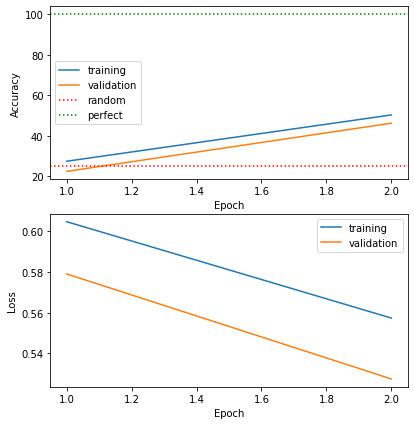

In [22]:
plot_learning_curve(learning_curve)